In [1]:
from Rosenbrock import Rosenbrock_dist
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import timeit

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [2]:
Bana_dist = Rosenbrock_dist()

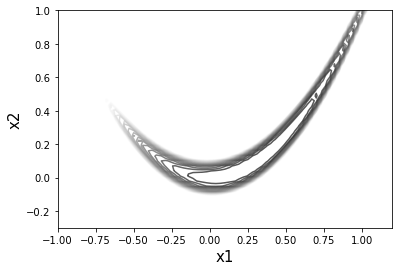

In [33]:
fig,ax = Bana_dist.draw_post()

In [7]:
def negative_log_posterior(mu):
    return tf.negative(Bana_dist.joint_log_post(mu))[0]

In [34]:
mu_init = tf.constant([[-0.6,0.4]])
Bana_dist.joint_log_post(mu_init)
ax.scatter(mu_init[0][0],mu_init[0][1] , c = 'r',zorder=10)
fig.savefig('/Users/zhouji/Documents/Presentations/IRTG 2020/figs/init.png',dpi=300)

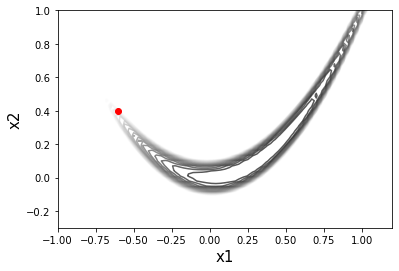

In [35]:
fig

In [10]:
# Function for printing
def loss(mu):
    lost =  negative_log_posterior(mu)
    return lost

# Function for tensorflow optimizer
def loss_minimize():
    lost =  negative_log_posterior(mu)
    return lost

In [17]:
Adam = tf.keras.optimizers.Adam(
    learning_rate=0.03, beta_1=0.9, beta_2=0.999, epsilon=1e-08
)
cost_A = []
mu_list = []
mu = tf.Variable(mu_init)
start = timeit.default_timer()

for step in range(300):

    Adam.minimize(loss_minimize, var_list=[mu])
    cost_A.append(loss(mu).numpy())

    mu_list.append(mu.numpy())
end = timeit.default_timer()

In [18]:
mu_list[-1]

array([[0.16487178, 0.02676925]], dtype=float32)

In [19]:
Mu_array = np.array(mu_list)

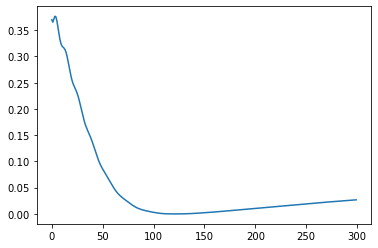

In [20]:
plt.plot(Mu_array[:,0,1])

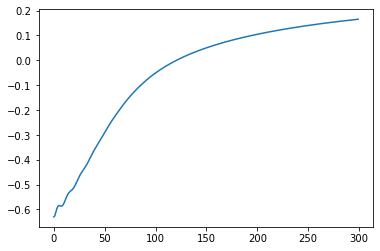

In [21]:
plt.plot(Mu_array[:,0,0])

In [36]:
ax.plot(Mu_array[:,0,0],Mu_array[:,0,1])
ax.scatter(Mu_array[-1,0,0],Mu_array[-1,0,1])
fig.savefig('/Users/zhouji/Documents/Presentations/IRTG 2020/figs/Adam.png',dpi=300)

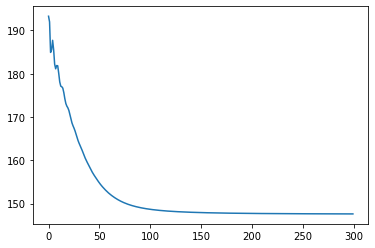

In [23]:
plt.plot(cost_A)

In [38]:
MAP = mu[-1]
MAP

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.16487178, 0.02676925], dtype=float32)>

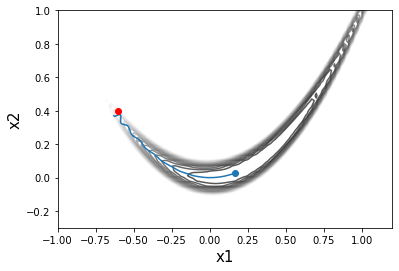

In [61]:
fig

In [57]:
def Hessian(MAP):
  Hess = tf.TensorArray(tf.float32, size=2)
  for i in range(2):

    tangents = np.zeros(MAP.shape)
    tangents[i]=1
    tangents = tf.convert_to_tensor(tangents,dtype=tf.float32)

    with tf.autodiff.ForwardAccumulator(MAP, tangents) as acc:
      with tf.GradientTape(watch_accessed_variables=False) as t:
        t.watch(MAP)
        joint_log =  loss(tf.expand_dims(MAP,axis=0))
      grad = t.gradient(joint_log,MAP)
    hess = acc.jvp(grad)
    Hess = Hess.write(i, hess)
  return(Hess.stack())

In [59]:
start = timeit.default_timer()
Hess = Hessian(MAP)
end = timeit.default_timer()
print('time for gradient calculation: %.3f' % (end - start))

time for gradient calculation: 0.025


In [63]:
Hess

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 103.88071, -259.61768],
       [-259.61768,  793.75385]], dtype=float32)>

In [65]:
def Laplace_appro(Hessian,C_prior):
    cov_post = tf.linalg.inv(
        (tf.add(Hessian, tf.linalg.inv(C_prior))))
    return cov_post

In [66]:
cov_post = Laplace_appro(Hess,tf.constant([[1,  0.], [0.,  1]]))

In [67]:
cov_post

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.04981843, 0.0162739 ],
       [0.0162739 , 0.00657435]], dtype=float32)>

In [60]:
from scipy.stats import multivariate_normal
x = np.linspace(-1, 1, 10, endpoint=False)
y = multivariate_normal.pdf(x, mean=MAP, cov=)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 103.88071, -259.61768],
       [-259.61768,  793.75385]], dtype=float32)>

In [51]:
mu_init

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.6,  0.4]], dtype=float32)>

In [55]:
tf.expand_dims(MAP,0)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.16487178, 0.02676925]], dtype=float32)>

<a href="http://blog.enthought.com/general/visualizing-uncertainty/#.XqC1GdP7RTY"> Plotting reference</a>

In [4]:
def pdense(x, y, sigma, M=1000):
    """ Plot probability density of y with known stddev sigma
    """
    assert len(x) == len(y) and len(x) == len(sigma)
    N = len(x)
    # TODO: better y ranging
    ymin, ymax = min(y - 2 * sigma), max(y + 2 * sigma)
    yy = np.linspace(ymin, ymax, M)
    a = [np.exp(-((Y - yy) / s) ** 2) / s for Y, s in zip(y, sigma)]
    A = np.array(a)
    A = A.reshape(N, M)
    plt.imshow(-A.T, cmap='gray', aspect='auto',
               origin='lower', extent=(min(x)[0], max(x)[0], ymin, ymax))
    plt.title('Density plot')

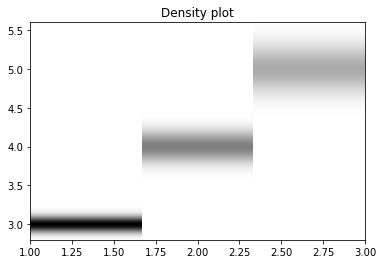

In [5]:
x = np.array([[1],[2],[3]])
y = np.array([[3],[4],[5]])
s2 = np.array([[0.1],[0.2],[0.3]])
pdense(x, y, s2, M=1000)